In [1]:
%matplotlib inline
from dataclasses import dataclass
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import rosbag
import scipy.optimize
from angles import shortest_angular_distance
from ruvu_odometry_calibration.odometry_calibration import to_matrix, pairs, inverse_odometry, odometry, DataPoint, Parameters, loss
from ruvu_odometry_calibration.tf2_rosbag import BagBuffer
from tf.transformations import inverse_matrix, translation_from_matrix, \
    euler_from_matrix, identity_matrix
from tf2_ros import ExtrapolationException

# bag_file_path = '/home/ramon/2021-02-26-13-55-27_filtered.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-40-17_error.bag'
# bag_file_path = '/home/ramon/2021-03-04-13-29-35_tuned.bag'
# bag_file_path = '/home/ramon/2021-03-05-13-43-38_linear_error.bag'
bag_file_path = '/home/ramon/2021-03-05-14-30-29_angle_error.bag'

bag = rosbag.Bag(bag_file_path)
bag_transformer = BagBuffer(bag)

/home/ramon/ros/movigo/src/odometry_calibration/ruvu_odometry_calibration/src/ruvu_odometry_calibration/tf2_rosbag.py:15: UserWarning: translation should be of type Vector3
  self.set_transform(tf, 'rosbag')
/home/ramon/ros/movigo/src/odometry_calibration/ruvu_odometry_calibration/src/ruvu_odometry_calibration/tf2_rosbag.py:15: UserWarning: rotation should be of type Quaternion
  self.set_transform(tf, 'rosbag')


In [2]:
data = []
for _, msg, _ in bag.read_messages(topics=['/scan']):
    try:
        ground_truth = bag_transformer.lookup_transform('map', 'base_link', msg.header.stamp)
        measurement = bag_transformer.lookup_transform('odom', 'base_link', msg.header.stamp)
    except ExtrapolationException:
        continue
    ground_truth = to_matrix(ground_truth)
    measurement = to_matrix(measurement)
    data.append(DataPoint(timestamp=msg.header.stamp, ground_truth=ground_truth, measurement=measurement))

    
print('total', len(data), 'data points')
results = []
partitions = np.unique(np.logspace(0, 1.5, 20).astype(int))
for i in partitions:
    subset = data[::i]
    print('using', len(subset), 'data points')
    
    
    def f(x):
        parameters = Parameters(x[0], x[1])
        errs = loss(subset, parameters)
#         print('err:', np.linalg.norm(errs), parameters)
        return np.ndarray.flatten(errs)

    
    bounds = (0.5, 2)
    result = scipy.optimize.least_squares(f, [1, 1], bounds=list(zip(bounds, bounds)))
    results.append(result)

    
print('example result:', results[0])

total 594 data points
using 594 data points
using 297 data points
using 198 data points
using 149 data points
using 119 data points
using 99 data points
using 85 data points
using 75 data points
using 60 data points
using 50 data points
using 40 data points
using 33 data points
using 29 data points
using 23 data points
using 20 data points
example result:  active_mask: array([0, 0])
        cost: 0.007562242540665397
         fun: array([-3.55271368e-15,  0.00000000e+00,  0.00000000e+00, ...,
       -3.55271368e-15,  0.00000000e+00,  2.74359188e-18])
        grad: array([ 3.17623260e-09, -5.15383848e-10])
         jac: array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 5
        njev: 5
  optimality: 1.2486935081597588e-09
      status: 1
     success: True
           x: array([0.89313667, 1.00582434])


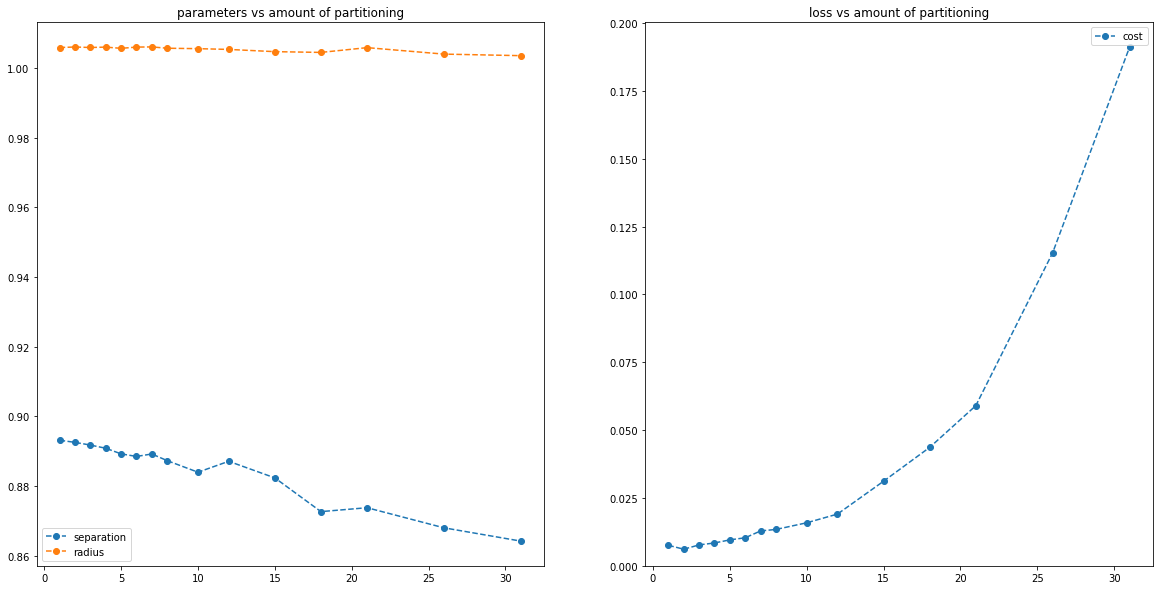

In [3]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.plot(partitions, [r.x[0] for r in results], 'o--', label='separation')
ax.plot(partitions, [r.x[1] for r in results], 'o--', label='radius')
ax.legend()
ax.set_title('parameters vs amount of partitioning')

ax = fig.add_subplot(1, 2, 2)
ax.plot(partitions, [r.cost for r in results], 'o--', label='cost')
ax.legend()
ax.set_title('loss vs amount of partitioning')
ax.set_ylim(bottom=0);